## Preprocesamiento

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import joblib

In [12]:
dataset = pd.read_csv('data/data.csv')

In [13]:
numeric_features = ['extent']
categorical_features = ['growth_stage', 'damage', 'season']

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [15]:


transformers_encoder_onehot = [
    ('encoder', OneHotEncoder(), categorical_features)
]
column_transformer = ColumnTransformer(transformers_encoder_onehot, remainder='passthrough')

In [16]:
dataset_encoded = column_transformer.fit_transform(dataset)
dataset = pd.DataFrame(dataset_encoded, columns=column_transformer.get_feature_names_out())

In [17]:
new_column_names = [col.replace('encoder__', '').replace('remainder__', '') for col in column_transformer.get_feature_names_out()]
dataset.columns = new_column_names

In [18]:
dataset = dataset.drop(columns=['ID'])

In [10]:
dataset.head()

,growth_stage_F,growth_stage_M,growth_stage_S,growth_stage_V,damage_DR,damage_DS,damage_FD,damage_G,damage_ND,damage_PS,damage_WD,damage_WN,season_LR2020,season_LR2021,season_SR2020,season_SR2021,filename,extent
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,L427F01330C01S03961Rp02052.jpg,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L1083F00930C39S12674Ip.jpg,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24_initial_1_1463_1463.JPG,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,L341F00167C01S00324Rp14178.jpg,60
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L1084F02394C39S13931Ip.jpg,0


In [9]:
def resizeImg(path, size):
    img = Image.open(path)

    width, height = img.size
    aspectRatio = width / height

    if aspectRatio < 1:
        nHeight = size
        nWidth = int(size * aspectRatio)
    else:
        nWidth = size
        nHeight = int(size / aspectRatio)

    resizedImg = img.resize((nWidth, nHeight), Image.LANCZOS)

    newImg = Image.new("RGB", (size, size), (255, 255, 255))

    xOffset = (size - nWidth) // 2
    yOffset = (size - nHeight) // 2
    newImg.paste(resizedImg, (xOffset, yOffset))

    return newImg

In [12]:
import os
from tqdm import tqdm

# Ruta donde se encuentran las imágenes
image_path = "data/train/"
image_size = 128
output_file = "resized_images.npy"

def load_and_resize_images(df, path, size):
    images = []
    for filename in tqdm(df['filename']):
        img = resizeImg(os.path.join(path, filename), size)
        img_array = np.array(img) / 255.0
        images.append(img_array)
    return np.array(images)

# Verificar si ya existe el archivo .npy
if not os.path.exists(output_file):
    images = load_and_resize_images(dataset, image_path, image_size)
    np.save(output_file, images)  # Guardar el archivo .npy
else:
    images = np.load(output_file)  # Cargar el archivo .npy


### Aumentar conjunto de datos

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
num_augmented_images_per_original = 3  # Número de imágenes aumentadas por cada imagen original
augmented_metadata = [] # Metadata de imágenes aumentadas
batch_size = 32

df_filtered = dataset[dataset["extent"] > 0].reset_index(drop=True)

def preprocess_image(filename, size):
    img_path = os.path.join(image_path, filename)
    img = Image.open(img_path)
    img = img.resize((size, size), Image.LANCZOS)
    img_array = np.array(img) / 255.0
    return img_array

# Cargar y procesar imágenes en batches
for start_idx in tqdm(range(0, len(df_filtered), batch_size)):
    end_idx = min(start_idx + batch_size, len(df_filtered))
    batch_filenames = df_filtered.loc[start_idx:end_idx, 'filename'].values
    batch_images = np.array([preprocess_image(f, image_size) for f in batch_filenames])
    
    # Expandir dimensiones si las imágenes son en escala de grises
    if batch_images.ndim == 3:
        batch_images = np.expand_dims(batch_images, axis=-1)
    
    # Generar imágenes aumentadas en batches
    augmented_batch = datagen.flow(
        batch_images,
        batch_size=len(batch_images),
        shuffle=False
    )

    # Añadir imágenes aumentadas al array 'images'
    for i in range(num_augmented_images_per_original):
        augmented_images_batch = next(augmented_batch)

        # Agregar imágenes al array `images` y metadata
        images = np.append(images, augmented_images_batch, axis=0)
        for j, filename in enumerate(batch_filenames):
            augmented_metadata_row = df_filtered.iloc[start_idx + j].copy()
            augmented_metadata_row['filename'] = f"aug_{filename.split('.')[0]}_{i}"
            augmented_metadata.append(augmented_metadata_row)

100%|██████████| 141/141 [17:31<00:00,  7.45s/it]


In [14]:
np.save("CNN_RandomForest/full_images.npy", images)

In [15]:
# Crear DataFrame de metadata aumentada
augmented_metadata_df = pd.DataFrame(augmented_metadata)

# Concatenar con el DataFrame original
final_metadata_df = pd.concat([dataset, augmented_metadata_df], ignore_index=True)

In [17]:

final_metadata_df.to_csv("CNN_RandomForest/full_metadata.csv", index=False)

In [16]:
final_metadata_df.shape

(40018, 18)

## CNN

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [13]:
# Cargar el modelo preentrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# Extraer las características de la última capa convolucional
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [20]:
# Extraer características de imágenes originales
features = model.predict(images)
features_flat = features.reshape(len(features), -1)

477/477 ━━━━━━━━━━━━━━━━━━━━ 2010s 4s/step


In [21]:
# Convertir las características a un DataFrame y unir con el dataset original
features_df = pd.DataFrame(features_flat)
df_full_data = pd.concat([final_metadata_df.reset_index(drop=True), features_df], axis=1)
df_full_data.drop(columns=["filename"], inplace=True)  # Retirar la columna 'filename',ahora tenemos las features

In [22]:
# Guardar el dataset con las características extraídas
df_full_data.to_csv("CNN_RandomForest/full_metadata_and_features.csv", index=False)

In [2]:
# Cargar el dataset de datos reales
df_full_data = pd.read_csv("CNN_RandomForest/full_metadata_and_features.csv")

## Random Forest

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [4]:
# Dividir datos
X = df_full_data.drop(columns=["extent"])
y = df_full_data["extent"]

# Convertir nombres de columnas a tipo string
X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Entrenar el modelo Random Forest
model_rf = RandomForestRegressor( 
    n_estimators=100,
          # Limitar la profundidad
    max_features='sqrt',   # Limitar el número de características en cada división
    random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=42)

In [ ]:
# Grid search

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}
model_rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(model_rf, param_grid, n_iter=10, cv=3, random_state=42)
random_search.fit(X_train, y_train)

In [ ]:

print(f"Best parameters: {random_search.best_params_}")

Mejores parámetros: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'max_features': 'sqrt'}


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluar el modelo
y_pred = model_rf.predict(X_test)

# Calcular RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

# Calcular R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

RMSE: 16.61455048629723
R²: 0.6052597294028865


d:\proyectosProgra\ds\proyecto3\entorno-proyecto\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Validación cruzada

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Usar RMSE como métrica de evaluación en la validación cruzada
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Aplicar validación cruzada
cv_scores = cross_val_score(model_rf, X, y, cv=5, scoring=rmse_scorer)

# Imprimir resultados de validación cruzada
print(f"RMSE para cada fold de validación cruzada: {cv_scores}")
print(f"RMSE promedio: {np.mean(cv_scores)}")
print(f"Desviación estándar de RMSE: {np.std(cv_scores)}")


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_reg

RMSE para cada fold de validación cruzada: [8.51452233 8.25258047 9.12848175 8.02106844 8.6620312 ]
RMSE promedio: 8.515736838548188
Desviación estándar de RMSE: 0.37704322085867964


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Visualizando el primer registro del conjunto de prueba
single_example = X_test.iloc[0].values.reshape(1, -1)  # Redimensionar para que sea un array de 2D

# Hacer la predicción
single_prediction = model_rf.predict(single_example)

print(f"\nValor real para el ejemplo: {y_test.iloc[0]}")
print(f"Predicción para el ejemplo: {single_prediction[0]}")


Valor real para el ejemplo: 30
Predicción para el ejemplo: 34.0


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [7]:
# Seleccionar varios ejemplos del conjunto de prueba
num_examples = 100  # Número de ejemplos a observar
examples = X_test.iloc[:num_examples]  # Seleccionar los primeros ejemplos
true_values = y_test.iloc[:num_examples]  # Valores reales correspondientes

# Hacer predicciones para varios ejemplos
predictions = model_rf.predict(examples)

# Mostrar resultados
for i in range(num_examples):
    print(f"\nEjemplo {i+1}:")
    print(f"Valor real: {true_values.iloc[i]}")
    print(f"Predicción: {predictions[i]}")


Ejemplo 1:
Valor real: 50
Predicción: 34.68077300377425

Ejemplo 2:
Valor real: 0
Predicción: 0.0

Ejemplo 3:
Valor real: 0
Predicción: 0.0

Ejemplo 4:
Valor real: 0
Predicción: 8.7

Ejemplo 5:
Valor real: 20
Predicción: 43.0540458232478

Ejemplo 6:
Valor real: 90
Predicción: 56.45073493227294

Ejemplo 7:
Valor real: 0
Predicción: 0.0

Ejemplo 8:
Valor real: 0
Predicción: 0.0

Ejemplo 9:
Valor real: 60
Predicción: 35.86768367079542

Ejemplo 10:
Valor real: 40
Predicción: 42.01375583376821

Ejemplo 11:
Valor real: 0
Predicción: 15.2

Ejemplo 12:
Valor real: 20
Predicción: 56.45073493227294

Ejemplo 13:
Valor real: 0
Predicción: 8.6

Ejemplo 14:
Valor real: 20
Predicción: 34.68077300377425

Ejemplo 15:
Valor real: 0
Predicción: 0.0

Ejemplo 16:
Valor real: 0
Predicción: 0.0

Ejemplo 17:
Valor real: 0
Predicción: 0.0

Ejemplo 18:
Valor real: 0
Predicción: 10.7

Ejemplo 19:
Valor real: 80
Predicción: 56.45073493227294

Ejemplo 20:
Valor real: 20
Predicción: 56.45073493227294

Ejemplo 21:


### Guardar modelo

In [8]:
# Guardar el modelo entrenado
joblib.dump(model_rf, "models/random_forest_aug_model.pkl")

['models/random_forest_aug_model.pkl']

In [ ]:
model.save("models/model_vgg16.keras")

In [ ]:
# Exportar el ColumnTransformer utilizado para codificación one-hot
joblib.dump(column_transformer, "models/column_transformer.pkl")

['CNN_RandomForest/column_transformer.pkl']

### Graficar imporancia del modelo

In [ ]:
import joblib
# Cargar el modelo entrenado
model = joblib.load("models/random_forest_aug_model.pkl")


In [15]:
import matplotlib.pyplot as plt

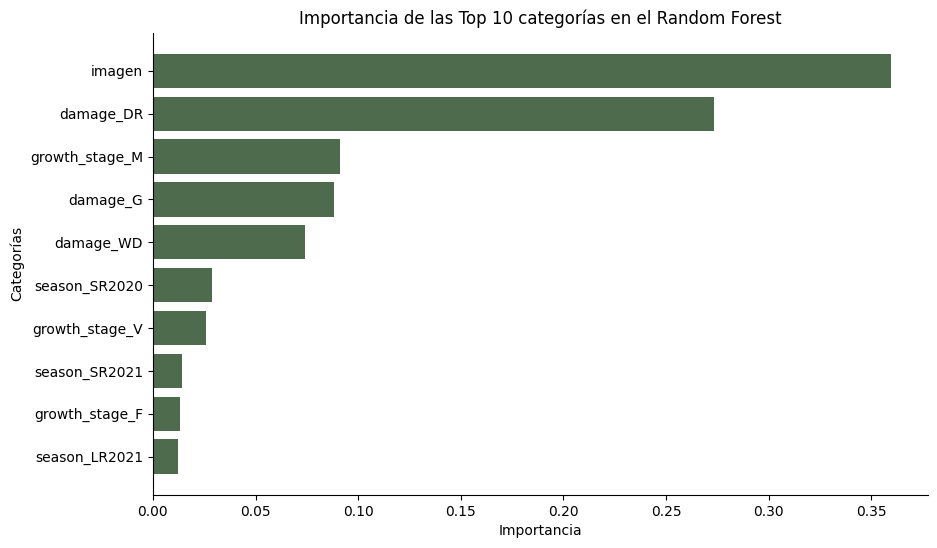

In [30]:
# Obtener la importancia de cada característica
importances = model.feature_importances_
features = X.columns

# Crear un DataFrame con la importancia
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Agrupar las características con nombres numéricos bajo la categoría "imagen"
importance_df['Feature'] = importance_df['Feature'].apply(lambda x: 'imagen' if x.isdigit() else x)

# Sumar las importancias de todas las columnas categorizadas como "imagen"
grouped_importances = (
    importance_df.groupby('Feature')['Importance'].sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Limitar a las N categorías más importantes
N = 10  # Puedes ajustar este valor
top_features = grouped_importances.iloc[:N]

# Graficar la importancia de cada categoría
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='#4e6b4d')
plt.xlabel('Importancia')
plt.ylabel('Categorías')
plt.title(f'Importancia de las Top {N} categorías en el Random Forest')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis()
plt.show()